<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/sports_facility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# スポーツ施設(体育館、プール、運動場)
- input:
    - 区ごとの運動施設の位置情報
- output:
    - exercise_score.csv
        - 体育館スコア
        - プールスコア
        - 運動場スコア

In [1]:
!pip install -q geocoder
!pip install -q --upgrade xlrd
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
output_score_file = 'sports_score.csv'
output_master_file = 'sports_master.csv'

In [5]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse
import geocoder
import math
import io
import re
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

def number_to_kanji(str):
    return str.translate(str.maketrans({
        '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九',
        '1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '7':'七', '8':'八', '9':'九', '0':'十', 
    }))

# 緯度経度取得
def add_lat_lon(df_master):
    lats = []
    lons = []
    for i, row in df_master.iterrows():
        chocho = number_to_kanji(row['町丁目'])
        ret = geocoder.osm('東京都' + row['市区町村名'] + chocho, timeout=5)
        if not ret.ok:
            print(i, row['市区町村名'], chocho)
        lats.append(ret.lat)
        lons.append(ret.lng)
    df_copy = df_master.copy()
    df_copy['緯度'] = lats
    df_copy['経度'] = lons
    return df_copy

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [7]:
def get_tokyo_ward_city(address):
    _tmp = address.replace('東京都', '')
    m = re.search('^.*?[区市]', _tmp)
    cityname = m.group()
    return cityname if len(cityname) < 6 else None

def get_category_facility(name):
    if re.search('.*公園$', name) is not None:
        return '公園'
    if re.search('.*緑地$', name) is not None:
        return '公園'
    if re.search('.*緑道$', name) is not None:
        return '公園'
    if re.search('.*庭園$', name) is not None:
        return '公園'
    if re.search('.*児童遊園$', name) is not None:
        return '公園'
    if re.search('.*図書館$', name) is not None:
        return '図書館'
    if re.search('.*美術館$', name) is not None:
        return '文化施設'
    if re.search('.*博物館$', name) is not None:
        return '文化施設'
    if re.search('.*会館$', name) is not None:
        return '文化施設'
    if re.search('.*劇場$', name) is not None:
        return '文化施設'
    if re.search('アーツ', name) is not None:
        return '文化施設'
    if re.search('.*協会$', name) is not None:
        return '協会'
    if re.search('(プール|スイム|スイミング)', name) is not None:
        return 'プール'
    if re.search('(運動場|球技場|体育場|野球場|競技場|運動広場|庭球場)', name) is not None:
        return '運動場他'
    if re.search('(サッカー|フットサル|テニス|ソフトボール|グラウンド|グランド)', name) is not None:
        return '運動場他'
    if re.search('(体育館|トレーニング|武道館)', name) is not None:
        return '体育館'
    if re.search('スポーツ', name) is not None:
        return '運動場他'
    return None

In [8]:
def change_type(df_data):
    df_data['緯度'] = df_data['緯度'].astype(float)
    df_data['経度'] = df_data['経度'].astype(float)

In [9]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

## 0. 東京都

## 1. 千代田区


## 2. 中央区

## 3. 港区
- [スポーツ・健康増進施設・公衆浴場](https://catalog.data.metro.tokyo.lg.jp/dataset/t131032d0000000014/resource/84bb03cb-c38a-4381-b5bf-9d4d9ed5e889)

In [10]:
minato_sports_url = 'https://opendata.city.minato.tokyo.jp/dataset/bb1f719a-ffbe-4c29-a936-de0bf6a2d179/resource/d2d0e539-a18c-4f96-a6aa-7cd9e6f0676f/download/minatokushisetsujoho_sports.csv'
df_minato_sports = get_data_csv_url(minato_sports_url)
print(df_minato_sports.shape)

df_minato_sports['市区町村名'] = '港区'
df_minato_sports['施設分類'] = df_minato_sports['ページタイトル'].apply(get_category_facility)
df_minato_sports = df_minato_sports[
    (df_minato_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'ページタイトル':'名称'})[extract_columns].reset_index(drop=True)
change_type(df_minato_sports)
print(df_minato_sports.shape)

(18, 31)
(14, 6)


In [11]:
df_minato_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,プール,港南小学校屋内プール,港区,港区港南四丁目3番28号 港区立港南小学校1階,35.629570,139.749656
1,プール,高陵中学校屋内プール,港区,港区西麻布四丁目14番8号 港区立高陵中学校地下2階,35.657139,139.720463
2,運動場他,芝浦南ふ頭公園運動広場（かいがんぱ～く）,港区,港区海岸三丁目33番20号,35.637322,139.759891
3,運動場他,港区スポーツセンター,港区,港区芝浦一丁目16番1号 みなとパーク芝浦3～8階,35.646408,139.751501
4,運動場他,埠頭少年野球場,港区,港区海岸三丁目14番34号,35.641684,139.755597


## 4. 新宿区


## 5. 文京区
- [文化・スポーツ施設](https://catalog.data.metro.tokyo.lg.jp/dataset/t131059d0304010001/resource/4fb225b9-c79c-47bc-bfe3-adec3f729906)

In [12]:
bunkyo_sports_url = 'https://www.city.bunkyo.lg.jp/library/opendata-bunkyo/03bunka-kankou-sports/01bunka-sports/bunka-sports.csv'
df_bunkyo_sports = get_data_csv_url(bunkyo_sports_url, encoding='shift-jis')
print(df_bunkyo_sports.shape)

df_bunkyo_sports['市区町村名'] = '文京区'
df_bunkyo_sports = df_bunkyo_sports[df_bunkyo_sports['カテゴリ'] == 'スポーツ施設'].reset_index(drop=True)
df_bunkyo_sports['施設分類'] = df_bunkyo_sports['施設名'].apply(get_category_facility)
df_bunkyo_sports = df_bunkyo_sports[
    (df_bunkyo_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'施設名':'名称', '住所':'所在地'})[extract_columns].reset_index(drop=True)
change_type(df_bunkyo_sports)
print(df_bunkyo_sports.shape)

(15, 14)
(7, 6)


In [13]:
df_bunkyo_sports

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,文京総合体育館,文京区,東京都文京区本郷7丁目1番2号,35.708382,139.763180
1,運動場他,文京スポーツセンター,文京区,東京都文京区大塚3丁目29番2号,35.720522,139.736420
2,体育館,文京江戸川橋体育館,文京区,東京都文京区小日向1丁目7番4号,35.710603,139.735460
3,運動場他,六義公園運動場,文京区,東京都文京区本駒込6丁目16番10号,35.731305,139.745763
4,運動場他,小石川運動場,文京区,東京都文京区後楽1丁目8番23号,35.704965,139.746415
5,運動場他,後楽公園少年野球場,文京区,東京都文京区後楽1丁目6番25号,35.706528,139.748556
6,運動場他,竹早テニスコート,文京区,東京都文京区小石川5丁目9番1号,35.717161,139.739597


## 6. 台東区
- [スポーツ](https://catalog.data.metro.tokyo.lg.jp/dataset/t131067d0000000091/resource/a7138b99-a872-41fd-ab3b-361a8278bff7)

In [14]:
taito_sports_url = 'https://www.city.taito.lg.jp/kusei/online/opendata/seikatu/shisethutizujouhou.files/sisetu_13.csv'
df_taito_sports = get_data_csv_url(taito_sports_url, 'shift-jis')
print(df_taito_sports.shape)

df_taito_sports['市区町村名'] = '台東区'
df_taito_sports['施設分類'] = df_taito_sports['名称'].apply(get_category_facility)
df_taito_sports = df_taito_sports[
    (df_taito_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'X座標':'経度', 'Y座標':'緯度'})[extract_columns].reset_index(drop=True)
change_type(df_taito_sports)
print(df_taito_sports.shape)

(8, 8)
(8, 6)


In [15]:
df_taito_sports

,施設分類,名称,市区町村名,所在地,緯度,経度
0,プール,清島温水プール,台東区,東上野6丁目16番8号,35.713494,139.783434
1,運動場他,柳北スポーツプラザ,台東区,浅草橋5丁目1番8号（旧柳北小学校体育館）,35.699276,139.782265
2,運動場他,台東リバーサイドスポーツセンター,台東区,今戸1丁目1番10号,35.717405,139.804583
3,体育館,生涯学習センタートレーニングルーム,台東区,西浅草3丁目25番16号 生涯学習センター3階,35.717238,139.789697
4,運動場他,荒川河川敷運動公園運動場,台東区,足立区千住大川町12番1号先（荒川河川敷）,35.758178,139.800661
5,運動場他,江戸川河川敷野球場,台東区,埼玉県三郷市新和地先（江戸川河川敷）,35.819153,139.888761
6,運動場他,たなかスポーツプラザ,台東区,日本堤2丁目25番4号,35.727879,139.797257
7,プール,都立浅草高等学校温水プール(区民開放期間のみ）,台東区,今戸1丁目8番13号 都立浅草高等学校体育館棟地下1階,35.719356,139.802486


## 7. 墨田区
- [スポーツ施設](https://catalog.data.metro.tokyo.lg.jp/dataset/t131075d0000000097/resource/8544959b-5b18-4c8d-94ab-1f8db69f7445)


In [16]:
sumida_sports_url = 'https://www.city.sumida.lg.jp/kuseijoho/sumida_info/opendata/opendata_ichiran/shisetsu_data.files/sports.csv'
df_sumida_sports = get_data_csv_url(sumida_sports_url, 'shift-jis')
print(df_sumida_sports.shape)

df_sumida_sports['市区町村名'] = '墨田区'
df_sumida_sports['施設分類'] = df_sumida_sports['施設名称'].apply(get_category_facility)
df_sumida_sports = df_sumida_sports[
    (df_sumida_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'施設名称':'名称'})[extract_columns].reset_index(drop=True)
change_type(df_sumida_sports)
print(df_sumida_sports.shape)

(33, 6)
(28, 6)


In [17]:
df_sumida_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,墨田区総合体育館,墨田区,墨田区錦糸四丁目15番1号,35.699416,139.817188
1,運動場他,スポーツプラザ梅若,墨田区,墨田区墨田一丁目4番4号,35.729064,139.815837
2,体育館,立花体育館,墨田区,墨田区立花一丁目25番10号,35.705186,139.832020
3,運動場他,すみだスポーツ健康センター,墨田区,墨田区東墨田一丁目6番1号,35.716461,139.830555
4,プール,両国屋内プール,墨田区,墨田区横網一丁目8番1号 両国中学校内,35.697809,139.796259


## 8. 江東区
- [スポーツセンター](https://catalog.data.metro.tokyo.lg.jp/dataset/t131083d0000000007/resource/4ca870cd-859a-4f9e-8e57-38d9830aadc4)

In [18]:
koutou_sports_url = 'https://www.city.koto.lg.jp/012107/documents/131083_kotocity_public_facility-4_sports.csv'
df_koutou_sports = get_data_csv_url(koutou_sports_url, 'shift-jis')
print(df_koutou_sports.shape)

df_koutou_sports['施設分類'] = df_koutou_sports['名称'].apply(get_category_facility)
df_koutou_sports = df_koutou_sports[
    (df_koutou_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所':'所在地'})[extract_columns].reset_index(drop=True)
change_type(df_koutou_sports)
print(df_koutou_sports.shape)

(18, 39)
(17, 6)


In [19]:
df_koutou_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,深川スポーツセンター,江東区,江東区越中島1-2-18,35.670692,139.791745
1,運動場他,亀戸スポーツセンター,江東区,江東区亀戸8-22-1,35.700432,139.836565
2,運動場他,有明スポーツセンター,江東区,江東区有明2-3-5,35.633500,139.783824
3,運動場他,東砂スポーツセンター,江東区,江東区東砂4-24-1,35.679506,139.839551
4,運動場他,深川北スポーツセンター,江東区,江東区平野3-2-20,35.677172,139.805179


## 9. 品川区
- [文化・スポーツ施設・公園(csv形式)](https://catalog.data.metro.tokyo.lg.jp/dataset/t131091d0000000016/resource/bd07c1ef-65b9-4bfc-88bd-0e4771782cc4) -> 体育館、野球場

In [20]:
# 列がおかしいので読み込みできない
# shinagawa_sports_url = 'https://www.opendata.metro.tokyo.lg.jp/shinagawa/culture_sports_park.csv'
# df_shinagawa_sports = get_data_csv_url(shinagawa_sports_url, encoding='cp932')
df_shinagawa_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/品川区_文化スポーツ施設.csv'), encoding='cp932', names=['名称', '所在地', '備考', '緯度', '経度'], skiprows=1)
print(df_shinagawa_sports.shape)

df_shinagawa_sports['市区町村名'] = '品川区'
df_shinagawa_sports['施設分類'] = df_shinagawa_sports['名称'].apply(get_category_facility)
df_shinagawa_sports = df_shinagawa_sports
df_shinagawa_sports = df_shinagawa_sports[
    (df_shinagawa_sports['施設分類'].isin(['体育館', '運動場他', 'プール']))
][extract_columns].reset_index(drop=True)
df_shinagawa_sports = df_shinagawa_sports.drop_duplicates(subset=['所在地']).reset_index(drop=True)
change_type(df_shinagawa_sports)
print(df_shinagawa_sports.shape)

(314, 5)
(12, 6)


In [21]:
df_shinagawa_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,総合体育館,品川区,東京都品川区北品川5-6-11,35.624530,139.728488
1,運動場他,天王洲公園野球場,品川区,東京都品川区東品川2-5-42,35.620512,139.749802
2,運動場他,八潮北公園野球場,品川区,東京都品川区八潮1-3-1,35.612284,139.754404
3,運動場他,大井ふ頭中央海浜公園野球場,品川区,東京都品川区八潮4-1-19,35.590939,139.752439
4,運動場他,子供の森野球場,品川区,東京都品川区北品川3-10-13,35.616218,139.737565


## 10. 目黒区
- [公共施設_2022_06/29](https://data.bodik.jp/dataset/131105_public_facility/resource/f119ff15-e5e1-44e7-836f-aa5e20c9a46c) -> 体育館、プール

In [22]:
megro_facility_url = 'https://data.bodik.jp/dataset/8fb2f443-a8fd-47c6-a527-6a961fca8928/resource/f119ff15-e5e1-44e7-836f-aa5e20c9a46c/download/131105_public_facility_20220616.csv'
df_megro_facility = get_data_csv_url(megro_facility_url, 'cp932')
print(df_megro_facility.shape)

df_megro_facility['施設分類'] = df_megro_facility['名称'].apply(get_category_facility)
df_megro_facility = df_megro_facility[
    (df_megro_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所':'所在地'})[extract_columns].drop_duplicates(subset=['施設分類', '所在地']).reset_index(drop=True)
change_type(df_megro_facility)
print(df_megro_facility.shape)

(395, 24)
(15, 6)


In [23]:
df_megro_facility.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,中央体育館,目黒区,東京都目黒区目黒本町 5-22-8,35.619030,139.698961
1,体育館,駒場体育館,目黒区,東京都目黒区駒場 2-19-39,35.658083,139.680147
2,プール,駒場プール,目黒区,東京都目黒区駒場 2-19-39,35.658083,139.680147
3,運動場他,駒場庭球場・ゲートボール場,目黒区,東京都目黒区駒場 2-19-39,35.658083,139.680147
4,体育館,目黒区民センター体育館,目黒区,東京都目黒区目黒 2-4-36,35.635403,139.708472


## 11. 大田区


## 12. 世田谷区
- [スポーツ](https://www.city.setagaya.lg.jp/theme/kanko/005/index.html) -> CSVでない

## 13. 渋谷区
- [スポーツ施設](https://www.city.shibuya.tokyo.jp/shisetsu/sports/index.html) -> CSVでない

## 14. 中野区
- [中野区オープンデータ 公共施設一覧（公園等以外）](https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582.html) -> 体育館、運動場

In [24]:
nakano_facility_url = 'https://www.city.tokyo-nakano.lg.jp/dept/158100/d027582_d/fil/131148_public_facility.csv'
df_nakano_facility = get_data_csv_url(nakano_facility_url)
print(df_nakano_facility.shape)

df_nakano_facility['施設分類'] = df_nakano_facility['名称'].apply(get_category_facility)
df_nakano_facility = df_nakano_facility[
    (df_nakano_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所': '所在地'})[extract_columns].drop_duplicates(subset=['施設分類', '所在地']).reset_index(drop=True)
change_type(df_nakano_facility)
print(df_nakano_facility.shape)

(180, 39)
(7, 6)


In [25]:
df_nakano_facility.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,中野体育館,中野区,東京都中野区中野4-11-14,35.709118,139.662613
1,運動場他,鷺宮スポーツ・コミュニティプラザ,中野区,東京都中野区白鷺3-1-13,35.722069,139.636032
2,運動場他,中部スポーツ・コミュニティプラザ,中野区,東京都中野区中央3-19-1,35.700085,139.674225
3,運動場他,南部スポーツ・コミュニティプラザ,中野区,東京都中野区弥生町5-11-26,35.688080,139.668823
4,運動場他,上高田運動施設（野球場、庭球場）,中野区,東京都中野区上高田5-6-1,35.717289,139.678436


## 15. 杉並区
- [オープンデータ一覧](https://www2.wagmap.jp/suginami/opendata?type=shp&ly=930)

In [26]:
df_suginami_sports = pd.read_csv(os.path.join(DIR_NAME, 'original/杉並区_スポーツ施設.csv'))
print(df_suginami_sports.shape)

df_suginami_sports['施設分類'] = df_suginami_sports['分類'].str.strip()
df_suginami_sports.loc[df_suginami_sports['施設分類'] == '運動場', '施設分類'] = '運動場他'
df_suginami_sports['市区町村名'] = '杉並区'
df_suginami_sports = df_suginami_sports.rename(columns={'住所':'所在地'})[extract_columns]
change_type(df_suginami_sports)
print(df_suginami_sports.shape)

(21, 9)
(21, 6)


In [27]:
df_suginami_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,井草森公園運動場,杉並区,井草4丁目12番1号,35.726903,139.611067
1,運動場他,柏の宮公園庭球場,杉並区,浜田山2丁目5番1号,35.678948,139.625214
2,運動場他,TAC杉並区上井草スポーツセンター（運動場）,杉並区,上井草3丁目34番1号,35.722923,139.601737
3,運動場他,蚕糸の森公園運動場,杉並区,和田3丁目55番49号,35.697234,139.656746
4,運動場他,下高井戸運動場,杉並区,下高井戸3丁目26番1号,35.672959,139.635498


## 16. 豊島区
- [公共施設一覧](https://catalog.data.metro.tokyo.lg.jp/dataset/t131164d0000000010/resource/472e6a97-b350-4909-a939-76530a570324)

In [28]:
url_toshima_facility = 'https://www.opendata.metro.tokyo.lg.jp/toyoshima/R4_public_facility.csv'
df_toshima_facility = get_data_csv_url(url_toshima_facility, encoding='cp932')
print(df_toshima_facility.shape)

df_toshima_facility['施設分類'] = df_toshima_facility['名称'].apply(get_category_facility)
df_toshima_facility = df_toshima_facility[
    (df_toshima_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'住所': '所在地'})[extract_columns].reset_index(drop=True)
change_type(df_toshima_facility)
print(df_toshima_facility.shape)

(538, 24)
(9, 6)


In [29]:
df_toshima_facility

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,巣鴨体育館,豊島区,東京都豊島区巣鴨3-8-7,35.73415,139.73347
1,運動場他,池袋スポーツセンター,豊島区,東京都豊島区上池袋2-5-1,35.73480,139.71475
2,体育館,雑司が谷体育館,豊島区,東京都豊島区雑司が谷3-1-7,35.71957,139.71385
3,運動場他,南長崎中央公園スポーツセンター,豊島区,東京都豊島区南長崎4-13-5,35.72449,139.68369
4,体育館,豊島体育館,豊島区,東京都豊島区要町3-47-8,35.73994,139.68948
5,運動場他,西巣鴨体育場,豊島区,東京都豊島区西巣鴨4-22-19,35.74472,139.73116
6,運動場他,総合体育場,豊島区,東京都豊島区東池袋4-41-30,35.72938,139.72264
7,運動場他,三芳グランド,豊島区,埼玉県入間郡三芳町上富382-1,35.82965,139.51230
8,運動場他,荒川野球場,豊島区,東京都板橋区新河岸3荒川河川敷,35.79680,139.65254


## 17. 北区


## 18. 荒川区


## 19. 板橋区
- [どこでも誰でもおでかけマップオープンデータ（公共施設）](https://catalog.data.metro.tokyo.lg.jp/dataset/t131199d0000000761/resource/0fb29627-2244-4647-a2e4-3c1daef472ad) -> 体育館、プール

In [30]:
url_itabashi_facility = 'https://www.city.itabashi.tokyo.jp/_res/projects/default_project/_page_/001/006/127/r3-1.csv'
df_itabashi_facility = get_data_csv_url(url_itabashi_facility, encoding='shift-jis')
print(df_itabashi_facility.shape)

df_itabashi_facility['市区町村名'] = '板橋区'
df_itabashi_facility['施設分類'] = df_itabashi_facility['施設名称'].apply(get_category_facility)
df_itabashi_facility['緯度'] = df_itabashi_facility['GEOM'].apply(lambda x: x.split(':')[1])
df_itabashi_facility['経度'] = df_itabashi_facility['GEOM'].apply(lambda x: x.split(':')[0])
df_itabashi_facility = df_itabashi_facility[
    (df_itabashi_facility['施設分類'].isin(['体育館', '運動場他', 'プール']))
].rename(columns={'施設名称':'名称', '住所':'所在地'})[extract_columns]
change_type(df_itabashi_facility)
print(df_itabashi_facility.shape)

(128, 56)
(6, 6)


In [31]:
df_itabashi_facility

,施設分類,名称,市区町村名,所在地,緯度,経度
9,プール,高島平温水プール,板橋区,高島平8-28-1,35.788313,139.667867
38,体育館,上板橋体育館,板橋区,桜川1-3-1,35.753820,139.678944
72,体育館,小豆沢体育館,板橋区,小豆沢3-1-1,35.775401,139.701417
94,体育館,赤塚体育館,板橋区,赤塚5-6-1,35.774694,139.645030
109,運動場他,植村記念加賀スポーツセンター,板橋区,加賀1-10-5,35.750344,139.718980
127,運動場他,あずさわスポーツフィールド,板橋区,小豆沢３−１,35.775367,139.700633


## 20. 練馬区
- [体育館](https://catalog.data.metro.tokyo.lg.jp/dataset/t131202d0000000101/resource/a239eafb-449a-4e56-85fc-c6c0146e4f0e)

In [32]:
url_nerima_sports = 'https://www.city.nerima.tokyo.jp/kusei/tokei/opendata/opendatasite/sisetsujyouhou/taiikukan.files/56_taiikukan.csv'
df_nerima_sports = get_data_csv_url(url_nerima_sports, encoding='shift-jis')
print(df_nerima_sports.shape)

df_nerima_sports['市区町村名'] = '練馬区'
df_nerima_sports['施設分類'] = '体育館'
df_nerima_sports = df_nerima_sports[extract_columns]
change_type(df_nerima_sports)
print(df_nerima_sports.shape)

(7, 5)
(7, 6)


In [33]:
df_nerima_sports

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,桜台体育館,練馬区,練馬区桜台3-28-1,35.745553,139.666220
1,体育館,平和台体育館,練馬区,練馬区平和台2-12-5,35.759427,139.661423
2,体育館,光が丘体育館,練馬区,練馬区光が丘4-1-4,35.764067,139.630290
3,体育館,総合体育館,練馬区,練馬区谷原1-7-5,35.749539,139.621278
4,体育館,大泉学園町体育館,練馬区,練馬区大泉学園町5-14-24,35.765285,139.584097
5,体育館,上石神井体育館,練馬区,練馬区上石神井1-32-37,35.722472,139.587207
6,体育館,中村南スポーツ交流センター,練馬区,練馬区中村南1-2-32,35.729224,139.648692


## 21. 足立区
- 足立区_スポーツ施設

In [34]:
import xml.etree.ElementTree as ET

def dump_node(node, dump_list):
    if node.text is not None:
        node_txt = node.text.strip()
        if len(node_txt) > 0:
            dump_list.append(node_txt)
    for child in node:
        dump_node(child, dump_list)

In [35]:
tree = ET.parse(os.path.join(DIR_NAME, 'original/足立区_スポーツ施設.kml'))
dump_list = []
dump_node(tree.getroot(), dump_list)

key_list = ['名称', 'info', 'icon', 'URL', '所在地', '施設', '緯度', '経度', '緯度経度']
key_num = len(key_list)

node_dict_list = []
node_dict = {}
for index, item in enumerate(dump_list[13:]):
    key_index = index % key_num
    node_dict[key_list[key_index]] = item
    if key_index == (key_num-1):
        node_dict_list.append(node_dict)
        node_dict = {}

df_adachi_sports = pd.DataFrame(node_dict_list)
print(df_adachi_sports.shape)

(35, 9)


In [36]:
df_adachi_sports['市区町村名'] = '足立区'
df_adachi_sports['施設分類'] = df_adachi_sports['名称'].apply(get_category_facility)
df_adachi_sports = df_adachi_sports[
    df_adachi_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])
][extract_columns].reset_index(drop=True)
change_type(df_adachi_sports)
print(df_adachi_sports.shape)

(34, 6)


In [37]:
df_adachi_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,体育館,伊興地域体育館,足立区,〒121-0823 足立区伊興二丁目4番22号,35.791170,139.780962
1,体育館,梅田地域体育館,足立区,〒123-0851 足立区梅田七丁目33番1号,35.770594,139.798257
2,運動場他,扇野球場,足立区,〒123-0873 足立区扇二丁目地先・左岸,35.761140,139.765460
3,体育館,興本地域体育館,足立区,〒123-0844 足立区興野一丁目18番38号,35.768308,139.782314
4,運動場他,尾竹橋公園テニスコート,足立区,〒120-0045 足立区千住桜木二丁目16番1号,35.754859,139.786603


## 22. 葛飾区
- [スポーツ・レクリェーション施設](https://catalog.data.metro.tokyo.lg.jp/dataset/t131229d0000000002/resource/8c85a2eb-e273-402b-b558-07b19a6a3fae)

In [38]:
url_katsushika_sports = 'https://www.opendata.metro.tokyo.lg.jp/suisyoudataset/131229__public_facility_1.csv'
df_katsushika_sports = get_data_csv_url(url_katsushika_sports, encoding='shift-jis')
df_katsushika_sports = df_katsushika_sports.dropna(how='all').reset_index(drop=True)
print(df_katsushika_sports.shape)

df_katsushika_sports['施設分類'] = df_katsushika_sports['名称（例）'].apply(get_category_facility)
df_katsushika_sports = df_katsushika_sports[df_katsushika_sports['施設分類'].isin(['体育館', '運動場他', 'プール'])].reset_index(drop=True)
df_katsushika_sports = df_katsushika_sports.rename(columns={'名称（例）':'名称', '住所':'所在地', '軽度':'経度'})[extract_columns]
change_type(df_katsushika_sports)
print(df_katsushika_sports.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (2,3,4,5,7,8,12,22,24,25,39) have mixed types.Specify dtype option on import or set low_memory=False.
  


(32, 40)
(32, 6)


In [39]:
df_katsushika_sports.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,運動場他,水元総合スポーツセンターテニスコート,葛飾区,東京都葛飾区水元1-23-1,35.781811,139.858632
1,運動場他,葛飾にいじゅくみらい公園運動場テニスコート,葛飾区,東京都葛飾区新宿6‐3‐20,35.772071,139.865021
2,運動場他,奥戸総合スポーツセンターテニスコート,葛飾区,東京都葛飾区高砂1-2-1,35.740986,139.863686
3,運動場他,渋江公園テニスコート,葛飾区,東京都葛飾区東立石3-3-1,35.735989,139.843030
4,運動場他,東金町運動場テニスコート,葛飾区,東京都葛飾区東金町8-27-1,35.781024,139.887594


## 23. 江戸川区

## 運動マスタ

|No.|区名|データ|
|:----|:----|:----|
|0|東京都|なし|
|1|千代田区| |
|2|中央区||
|3|港区|済み|
|4|新宿区| |
|5|文京区|済み|
|6|台東区|済み|
|7|墨田区|済み|
|8|江東区|済み|
|9|品川区|済み|
|10|目黒区|済み|
|11|大田区| |
|12|世田谷区| |
|13|渋谷区||
|14|中野区|済み|
|15|杉並区|済み|
|16|豊島区|済み|
|17|北区| |
|18|荒川区| |
|19|板橋区|済み|
|20|練馬区|済み|
|21|足立区|済み|
|22|葛飾区|済み|
|23|江戸川区| |

In [40]:
df_sports_master = pd.concat([
    df_minato_sports,
    df_bunkyo_sports,
    df_taito_sports,
    df_sumida_sports,
    df_koutou_sports,
    df_shinagawa_sports,
    df_megro_facility,
    df_nakano_facility,
    df_suginami_sports,
    df_toshima_facility,
    df_itabashi_facility,
    df_nerima_sports,
    df_adachi_sports,
    df_katsushika_sports,
]).reset_index(drop=True)
print(df_sports_master.shape)

(217, 6)


In [41]:
df_sports_master.head()

,施設分類,名称,市区町村名,所在地,緯度,経度
0,プール,港南小学校屋内プール,港区,港区港南四丁目3番28号 港区立港南小学校1階,35.629570,139.749656
1,プール,高陵中学校屋内プール,港区,港区西麻布四丁目14番8号 港区立高陵中学校地下2階,35.657139,139.720463
2,運動場他,芝浦南ふ頭公園運動広場（かいがんぱ～く）,港区,港区海岸三丁目33番20号,35.637322,139.759891
3,運動場他,港区スポーツセンター,港区,港区芝浦一丁目16番1号 みなとパーク芝浦3～8階,35.646408,139.751501
4,運動場他,埠頭少年野球場,港区,港区海岸三丁目14番34号,35.641684,139.755597


In [42]:
df_sports_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

In [43]:
# データがある区をリストアップ
sr_count = df_sports_master['市区町村名'].value_counts()
ward_list = list(sr_count[sr_count > 0].index)
print(len(ward_list))

14


## 人口マスタ

In [44]:
population = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))
print(population.shape)
df_pop_master = population[population['市区町村名'].isin(ward_list)][['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']].reset_index(drop=True)
print(df_pop_master.shape)

(3145, 32)
(1839, 6)


In [45]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

## 各種スコア

In [46]:
%%time
# 一番近い施設の距離
df_pop_master['運動場(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_sports_master, '運動場他', 'min')
# 一番近い施設の距離
df_pop_master['体育館(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_sports_master, '体育館', 'min')
# 一番近い施設の距離
df_pop_master['プール(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_sports_master, 'プール', 'min')

# 3km以内の施設の数
df_pop_master['運動場(数)'] = get_value_of_nearest_facility(df_pop_master, df_sports_master, '運動場他', 'count', 3)
# 3km以内の施設の数
df_pop_master['体育館(数)'] = get_value_of_nearest_facility(df_pop_master, df_sports_master, '体育館', 'count', 3)
# 3km以内の施設の数
df_pop_master['プール(数)'] = get_value_of_nearest_facility(df_pop_master, df_sports_master, 'プール', 'count', 3)

CPU times: user 26.9 s, sys: 286 ms, total: 27.2 s
Wall time: 27 s


In [47]:
print(df_pop_master.shape)
df_pop_master.head()

(1839, 12)


,地域ID,市区町村名,町名,町丁目,緯度,経度,運動場(最近傍距離),体育館(最近傍距離),プール(最近傍距離),運動場(数),体育館(数),プール(数)
0,103003,港区,芝,芝１丁目,35.651019,139.754999,0.557138,3.796813,1.254376,6,0,6
1,103004,港区,芝,芝２丁目,35.651370,139.751891,0.373750,3.657936,1.152263,6,0,7
2,103005,港区,芝,芝３丁目,35.652304,139.747678,0.369513,3.541954,1.068910,6,0,6
3,103006,港区,芝,芝４丁目,35.648348,139.751136,0.218276,3.347219,1.481813,6,0,7
4,103007,港区,芝,芝５丁目,35.647148,139.746984,0.416402,3.019811,1.339396,7,0,6


In [48]:
all_feature_list = []
all_score_list = []

### 運動場スコア

In [49]:
score_name = '運動場スコア'
feature_list = {
    '運動場(最近傍距離)':     {'high': False, 'outlier': True, 'weight': 1}, 
    '運動場(数)':             {'high': True, 'outlier': False, 'weight': 1},
}
all_feature_list += list(feature_list.keys())

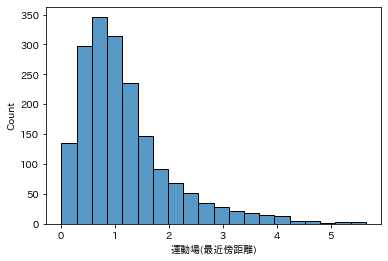

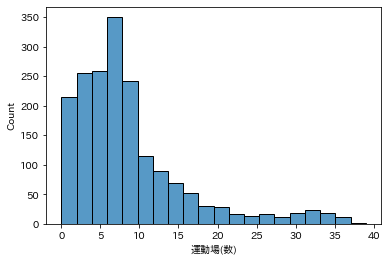

In [50]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

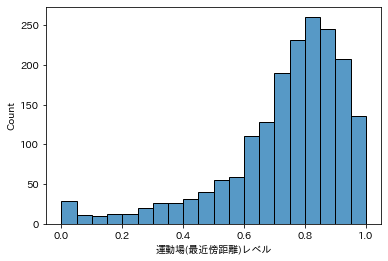

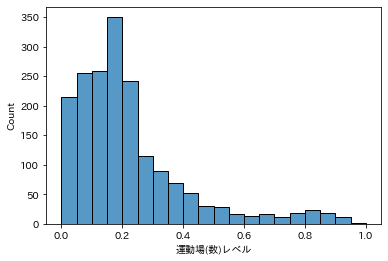

In [51]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

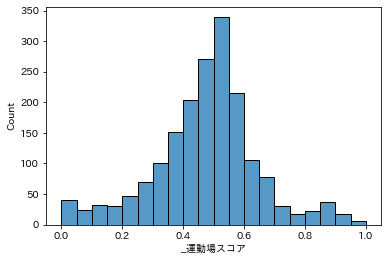

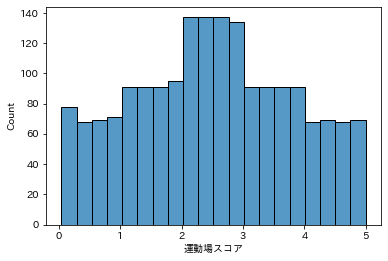

In [52]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

all_score_list += total_score_list

### 体育館スコア

In [53]:
score_name = '体育館スコア'
feature_list = {
    '体育館(最近傍距離)':     {'high': False, 'outlier': True, 'weight': 1}, 
    '体育館(数)':             {'high': True, 'outlier': False, 'weight': 1},
}
all_feature_list += list(feature_list.keys())

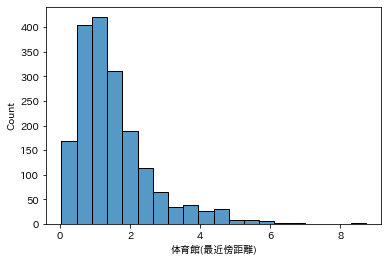

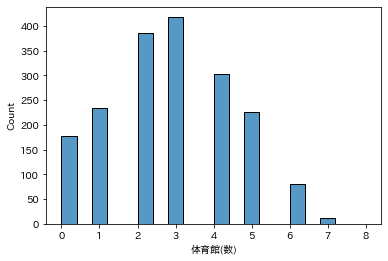

In [54]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

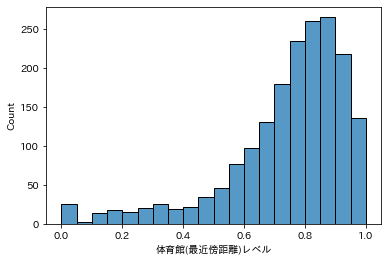

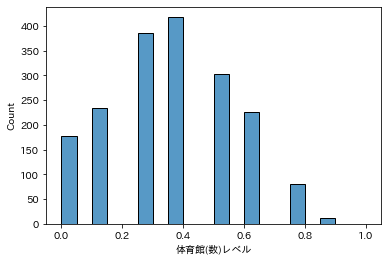

In [55]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

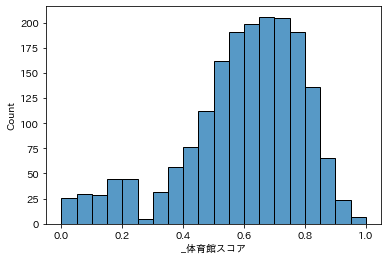

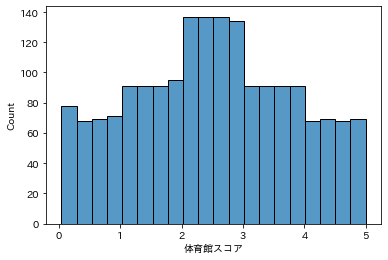

In [56]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

all_score_list += total_score_list

### プールスコア

In [57]:
score_name = 'プールスコア'
feature_list = {
    'プール(最近傍距離)':     {'high': False, 'outlier': True, 'weight': 1}, 
    'プール(数)':             {'high': True, 'outlier': False, 'weight': 1},
}
all_feature_list += list(feature_list.keys())

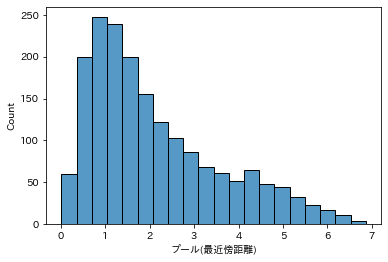

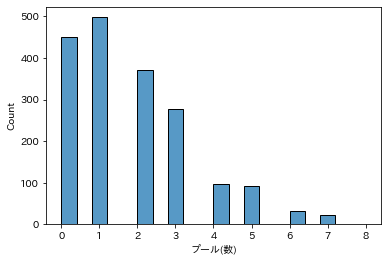

In [58]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

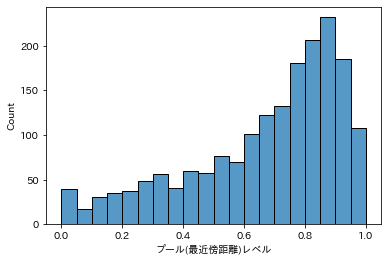

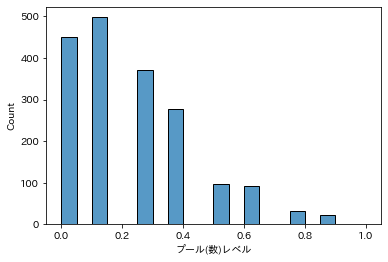

In [59]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

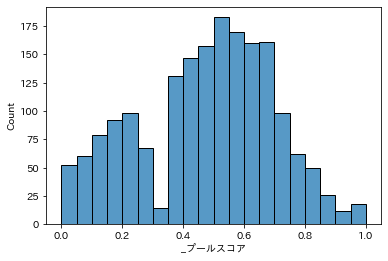

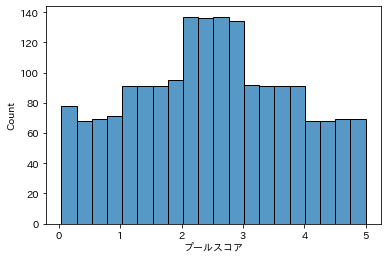

In [60]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

all_score_list += total_score_list

In [61]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,緯度,経度,運動場(最近傍距離),体育館(最近傍距離),プール(最近傍距離),運動場(数),体育館(数),プール(数),運動場(最近傍距離)レベル,運動場(数)レベル,_運動場スコア,運動場スコア,体育館(最近傍距離)レベル,体育館(数)レベル,_体育館スコア,体育館スコア,プール(最近傍距離)レベル,プール(数)レベル,_プールスコア,プールスコア
0,103003,港区,芝,芝１丁目,35.651019,139.754999,0.557138,3.796813,1.254376,6,0,6,0.886981,0.153846,0.520414,2.851116,0.316000,0.0,0.172060,0.370169,0.817835,0.750,0.836179,4.764108
1,103004,港区,芝,芝２丁目,35.651370,139.751891,0.373750,3.657936,1.152263,6,0,7,0.930858,0.153846,0.542352,3.176783,0.342131,0.0,0.186288,0.431864,0.835195,0.875,0.912104,4.905643
2,103005,港区,芝,芝３丁目,35.652304,139.747678,0.369513,3.541954,1.068910,6,0,6,0.931872,0.153846,0.542859,3.187670,0.363954,0.0,0.198171,0.457267,0.849365,0.750,0.852995,4.804028
3,103006,港区,芝,芝４丁目,35.648348,139.751136,0.218276,3.347219,1.481813,6,0,7,0.968057,0.153846,0.560951,3.468019,0.400594,0.0,0.218121,0.515333,0.779170,0.875,0.882224,4.862094
4,103007,港区,芝,芝５丁目,35.647148,139.746984,0.416402,3.019811,1.339396,7,0,6,0.920653,0.179487,0.550070,3.312874,0.462198,0.0,0.251664,0.635093,0.803381,0.750,0.828470,4.724188


## 保存

In [62]:
all_feature_list

['運動場(最近傍距離)', '運動場(数)', '体育館(最近傍距離)', '体育館(数)', 'プール(最近傍距離)', 'プール(数)']

In [63]:
all_score_list

['_運動場スコア', '運動場スコア', '_体育館スコア', '体育館スコア', '_プールスコア', 'プールスコア']

In [64]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

## 区ごとのスコア確認

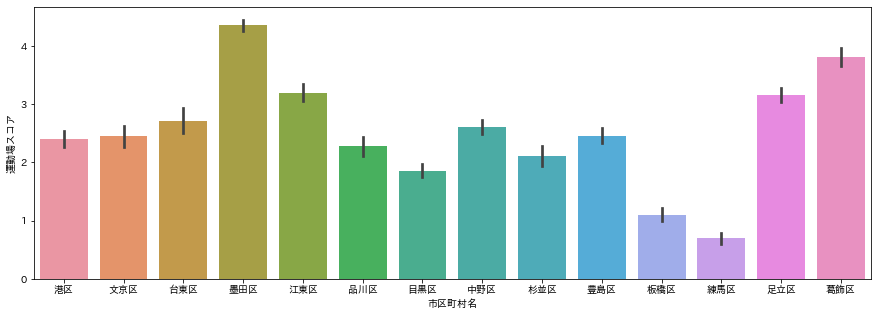

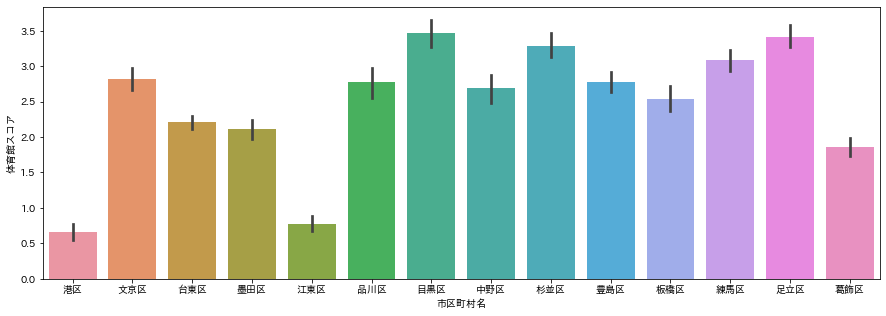

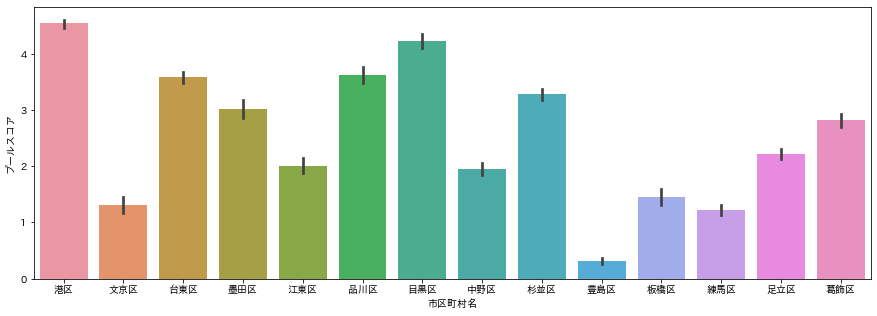

In [65]:
for _score in ['運動場スコア', '体育館スコア', 'プールスコア']:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_pop_master)
    plt.show()

In [66]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + total_score_list + list(feature_list.keys())
].reset_index(drop=True)
print(df_level.shape)

(491, 7)


In [67]:
df_level.head(20)

,市区町村名,町名,町丁目,_プールスコア,プールスコア,プール(最近傍距離),プール(数)
0,目黒区,目黒,目黒２丁目,1.000000,4.998185,0.056938,7
1,港区,南麻布,南麻布３丁目,1.000000,4.998185,0.076796,7
2,品川区,上大崎,上大崎３丁目,0.992323,4.989113,1.002791,8
3,港区,高輪,高輪２丁目,0.977089,4.981854,0.435534,7
4,目黒区,三田,三田２丁目,0.972963,4.974596,0.481036,7
5,港区,白金,白金３丁目,0.972685,4.970967,0.484111,7
6,目黒区,中目黒,中目黒４丁目,0.966473,4.960080,0.552618,7
7,目黒区,下目黒,下目黒１丁目,0.960802,4.949193,0.615164,7
8,港区,西麻布,西麻布４丁目,0.933333,4.929232,0.129617,6
9,港区,白金台,白金台５丁目,0.913460,4.912901,1.137310,7


In [68]:
df_level.tail(20)

,市区町村名,町名,町丁目,_プールスコア,プールスコア,プール(最近傍距離),プール(数)
471,足立区,新田,新田３丁目,0.078130,0.308474,5.203339,0
472,板橋区,仲宿,仲宿,0.071999,0.283070,5.270963,0
473,板橋区,大山西町,大山西町,0.071967,0.279441,5.271317,0
474,板橋区,大山町,大山町,0.071638,0.275812,5.274945,0
475,豊島区,要町,要町２丁目,0.066306,0.257666,5.333757,0
476,練馬区,西大泉町,西大泉町,0.053147,0.203230,5.478886,0
477,板橋区,大山東町,大山東町,0.050253,0.192343,5.510799,0
478,板橋区,幸町,幸町,0.048324,0.185084,5.532076,0
479,豊島区,東池袋,東池袋５丁目,0.043777,0.177826,5.582233,0
480,豊島区,千川,千川１丁目,0.042267,0.174197,5.598888,0
